<a href="https://colab.research.google.com/github/ris0801/DeepLearning/blob/main/FashionMNISTUsingNeuralNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torchvision

time: 680 µs (started: 2023-02-17 21:26:36 +00:00)


In [ ]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.08 s (started: 2023-02-17 21:26:36 +00:00)


Training Simple Models

Downloading dataset for FashionMNIST

In [ ]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())

time: 80.7 ms (started: 2023-02-17 21:26:40 +00:00)


In [ ]:
print(len(trainingdata))
print(len(testdata))     

60000
10000
time: 1.15 ms (started: 2023-02-17 21:26:40 +00:00)


In [ ]:
image, label = trainingdata[0]
print(image.shape, label)

torch.Size([1, 28, 28]) 9
time: 4.04 ms (started: 2023-02-17 21:26:40 +00:00)


In [ ]:
print(image.squeeze().shape)

torch.Size([28, 28])
time: 477 µs (started: 2023-02-17 21:26:40 +00:00)


In [ ]:
print(image.shape)

torch.Size([1, 28, 28])
time: 665 µs (started: 2023-02-17 21:26:40 +00:00)


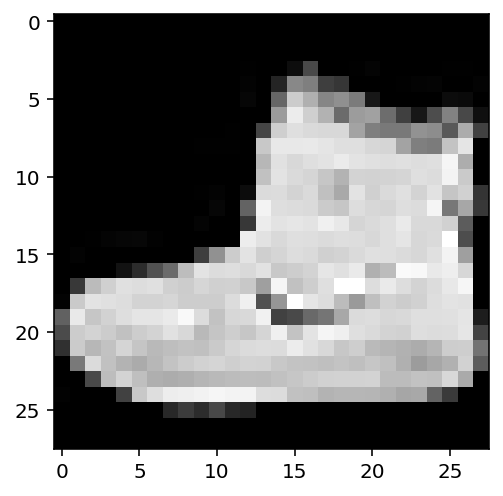

time: 202 ms (started: 2023-02-17 21:26:40 +00:00)


In [ ]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.imshow(image.squeeze(),cmap=plt.cm.gray)

Converting dataset to dataloader. 
It's nice for iterating over dataset

In [ ]:
#shuffling the trainData, common thing to do in neural network
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size = 64, shuffle = True)
# Why is shuffle false here?
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=64,shuffle = False)

time: 4.24 ms (started: 2023-02-17 21:26:40 +00:00)


In [ ]:
print(len(trainDataLoader))
print(len(testDataLoader))

938
157
time: 2.11 ms (started: 2023-02-17 21:26:40 +00:00)


In [ ]:
print(len(trainDataLoader) * 64)
print(len(testDataLoader) * 64)

60032
10048
time: 2.83 ms (started: 2023-02-17 21:26:40 +00:00)


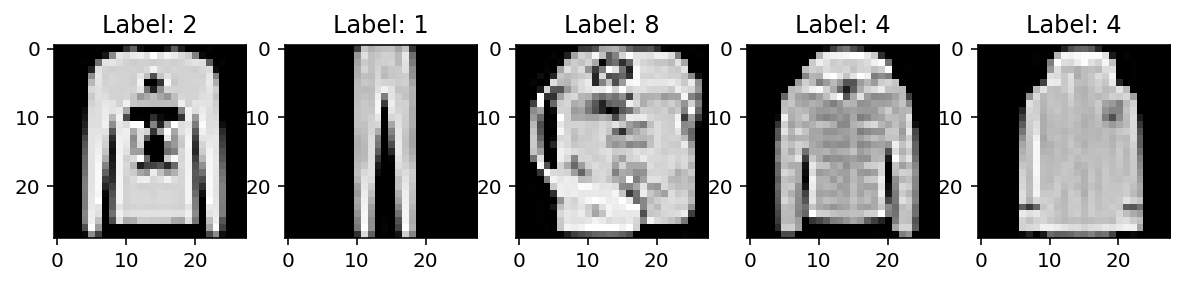

time: 591 ms (started: 2023-02-17 21:26:40 +00:00)


In [ ]:
#iter to create an iter object of trainDataLoader and next to get the first batch
images, labels = next(iter(trainDataLoader))

plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  # This tells to create one row, five columns
  plt.subplot(1,5,index+1)
  plt.title(f'Label: {labels[index].item()}')
  plt.imshow(images[index].squeeze(),cmap=plt.cm.gray)

Setting up the model

Creating the structure of neural network as mentioned in the question with three hidden layers with 256,128,64 hidden neurons. 
Using CrossEntropyLoss for this multi class classification problem, and adam as the optimizer. 
I have used relu as the activation of the neural network 

In [ ]:
class NeuralNet(torch.nn.Module):
     def __init__(self, input_size, hidden_size, num_classes):
         super(NeuralNet, self).__init__()
         self.input_size = input_size
         self.l1 = torch.nn.Linear(input_size, hidden_size) 
         self.relu = torch.nn.ReLU()
         self.l2 = torch.nn.Linear(256, 128) 
         self.l3 = torch.nn.Linear(128, 64) 
         self.l4 = torch.nn.Linear(64, num_classes)
     def forward(self, x):
         out = self.l1(x)
         out = self.relu(out)
         out = self.l2(out)
         out = self.relu(out)
         out = self.l3(out)
         out = self.relu(out)
         out = self.l4(out)
         return out 

model = NeuralNet(28*28, 256, 10).cuda()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 

time: 8.78 ms (started: 2023-02-17 21:26:41 +00:00)


*While* enumerating a batch, getting the predicted classes by getting the max of predicted probablities, storing all the correct predictions in correct_train and correct_test, accordigily for test and train and datasets. 
Using above to calculate the accuracy on test datsaset. 

Passing through the complete dataset 100 times (indicated by the number of epochs)

Maintaing a history of train_loss, test_loss and accuracy over epochs. 

In [ ]:
train_loss_history = []
test_loss_history = []
accuracy_test_history = []

# One epoch is passing over the training data once
for epoch in range(100):
  train_loss = 0.0
  test_loss = 0.0
  
  model.train()
  correct_train = 0
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    #Because we have our model on GPU, we need to push images and label on 
    #GPU as well
    # Reshaping the image and pushing to GPU
    images = images.reshape(-1, 28*28).cuda()
    # images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad() # zero out any gradient values from the previous iteration
    predicted_output = model(images) # forward propagation  
    fit = loss(predicted_output, labels)  # calculate our measure of goodness
    fit.backward() # backpropagation
    optimizer.step() # update the weights of our trainable parameters
    train_loss += fit.item()
    predicted_classes = torch.max(predicted_output, 1)[1]
    correct_train += (predicted_classes == labels).float().sum()
  accuracy_train = (correct_train) / 60000
  print("Accuracy on training data for epoch {} is {}".format(epoch, accuracy_train))

  # Setting to evaluation mode, so no gradients are computed 
  model.eval()
  correct_test = 0
  for i, data in enumerate(testDataLoader):
    #Telling pytorch again to not compute any gradients
    with torch.no_grad():
      images, labels = data
      images = images.reshape(-1, 28*28).cuda()
      labels = labels.cuda()
      predicted_output = model(images)
      fit = loss(predicted_output, labels)
      test_loss += fit.item()
      predicted_classes = torch.max(predicted_output, 1)[1]
      correct_test += (predicted_classes == labels).float().sum()
  accuracy_test = (correct_test) / 10000
  accuracy_test_history += [accuracy_test]
  print("Accuracy on test data for epoch {} is {}".format(epoch, accuracy_test))
  train_loss = train_loss / len(trainDataLoader)
  test_loss = test_loss / len(testDataLoader)
  train_loss_history += [train_loss]
  test_loss_history += [test_loss]
  print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}')


Accuracy on training data for epoch 0 is 0.8000333309173584
Accuracy on test data for epoch 0 is 0.8375999927520752
Epoch 0, Train loss 0.5521040716405108, Test loss 0.47340876234185164
Accuracy on training data for epoch 1 is 0.8483499884605408
Accuracy on test data for epoch 1 is 0.8384000062942505
Epoch 1, Train loss 0.42481565612878625, Test loss 0.4741671671912928
Accuracy on training data for epoch 2 is 0.8573833703994751
Accuracy on test data for epoch 2 is 0.8459999561309814
Epoch 2, Train loss 0.3991939752324939, Test loss 0.4196282727703167
Accuracy on training data for epoch 3 is 0.8621500134468079
Accuracy on test data for epoch 3 is 0.840999960899353
Epoch 3, Train loss 0.3870049348708663, Test loss 0.43995572085593154
Accuracy on training data for epoch 4 is 0.8677999973297119
Accuracy on test data for epoch 4 is 0.8540999889373779
Epoch 4, Train loss 0.3704046146002914, Test loss 0.42664471838124995
Accuracy on training data for epoch 5 is 0.8682667016983032
Accuracy on 

Accuracy on test data for epoch 100 is 0.8707999587059021

Plotting train vs test error 

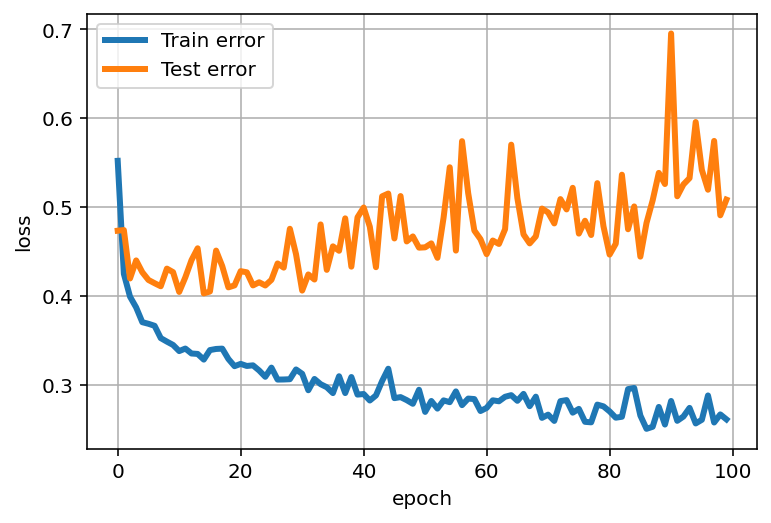

time: 163 ms (started: 2023-02-17 21:41:15 +00:00)


In [ ]:
plt.plot(range(100),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(100),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

Getting the predicted outputs and labels of last batch 

In [ ]:
predicted_outputs = model(images)
predicted_classes = torch.max(predicted_outputs, 1)[1]
print('Predicted:', predicted_classes)
fit = loss(predicted_output, labels)
print('True labels:', labels)
print(fit.item())

Predicted: tensor([3, 2, 7, 5, 8, 2, 5, 2, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0')
True labels: tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0')
0.23718209564685822
time: 7.69 ms (started: 2023-02-17 21:41:16 +00:00)


Reshaping the image back to 28*28

In [ ]:
images = [image.reshape(28,28) for image in images]

time: 802 µs (started: 2023-02-17 21:41:16 +00:00)


Printing 3 such images and predicting the probablities of all such classes

Predicted probablities for all classes are also printed 

tensor([ 1.2493e+00,  2.1236e+00, -1.7564e+00,  5.8348e+00,  4.0315e-02,
        -1.0745e+01,  6.7378e-01, -2.5876e+01, -2.1104e+00, -1.0167e+02],
       device='cuda:0')


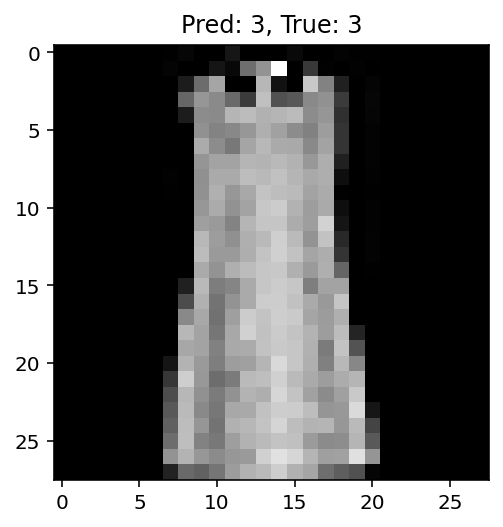

time: 175 ms (started: 2023-02-17 21:41:16 +00:00)


In [ ]:
plt.imshow(images[0].squeeze().cpu(), cmap=plt.cm.gray)
plt.title(f'Pred: {predicted_classes[0].item()}, True: {labels[0].item()}')
print(predicted_output[0])

For the above image, we can see the index 3 has higher probabilty than all other classes, and is also the right prediction.

tensor([  -2.9571,   -8.9350,    0.2727,   -5.0705,   -2.6250,  -42.6665,
          -1.7860,  -90.4055,   -5.5648, -126.4115], device='cuda:0')


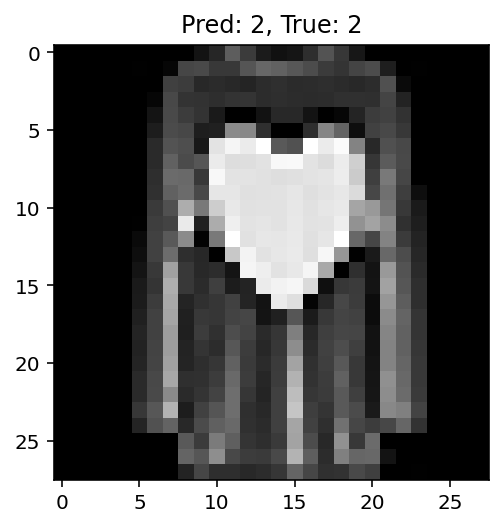

time: 164 ms (started: 2023-02-17 21:41:16 +00:00)


In [ ]:
plt.imshow(images[1].squeeze().cpu(), cmap=plt.cm.gray)
plt.title(f'Pred: {predicted_classes[1].item()}, True: {labels[1].item()}')
print(predicted_output[1])

For the above image, we can see the index 2 has higher probabilty (0.2727) than all other classes, and is also the right prediction. All other classes are having negative probablities. 

tensor([-104.2550,  -71.8597, -105.0970, -101.7491,  -78.2025,   -5.5526,
         -83.7825,   10.0736,  -22.0867,    0.1973], device='cuda:0')


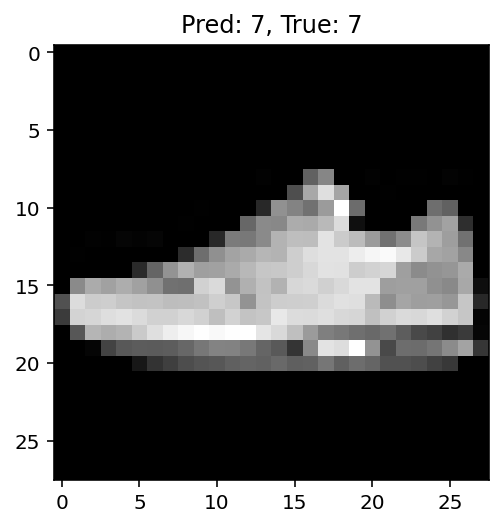

time: 288 ms (started: 2023-02-17 21:41:16 +00:00)


In [ ]:
plt.imshow(images[2].squeeze().cpu(), cmap=plt.cm.gray)
plt.title(f'Pred: {predicted_classes[2].item()}, True: {labels[2].item()}')
print(predicted_output[2])

For the above image, we can see the index 7 has higher probabilty (10.0736) than all other classes, and is also the right prediction. All other classes have much lower probablities. 